# **Part 1**

## Load Libraries/Data

In [51]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Regression Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Classification Models & evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables for next lesson/notebook
import joblib

# especially used when coverting log odds to regular odds
import math

import shap
from lime.lime_tabular import LimeTabularExplainer

import os

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)
import datetime as dt

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates


import warnings
warnings.filterwarnings('ignore')

In [38]:
plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'

## Custom Functions

### Linear Regression

In [47]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points', color='tab:blue'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize, color=color)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')    

    
    if annotate == True:
            for bar in ax.patches:
                ## calculate center of bar
                bar_ax = bar.get_y() + bar.get_height() / 2
                ## get the value to annotate
                val = bar.get_width()

                # handle negative values by setting them to position 0
                if val < 0:
                    val_pos = 0
                else:
                    val_pos = val        
        
                # ha and va stand for the horizontal and vertical alignment
                ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                            ha=ha, va=va, size=size,
                            xytext=xytext, textcoords=textcoords)
    return ax

In [43]:
def evaluate_regression(model, X_train=X_train_df,y_train=y_train, X_test=X_test_df, y_test=y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

### Random Forest Regression

In [52]:
def evaluate_classification(model, X_train=X_train_df, y_train=y_train,
                            X_test=X_test_df, y_test=y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

In [58]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True, permutation=False, random_state=SEED,
                   X_train=X_train_df, y_train=y_train, n_jobs=None):

    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    if permutation==False:
        importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
        
    if permutation==True:
        r = permutation_importance(model, X_train, y_train, n_repeats =5, 
                                   random_state = random_state, n_jobs=n_jobs)
        
        importances = pd.Series(r['importances_mean'],index=X_train.columns,
                           name = 'permutation importance')
    
        # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [53]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [54]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, color_rest='#006ba4', color_top='green',
                          top_important=5, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        highlight_feats = importances.sort_values(ascending=True).tail(top_important).index
        colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}        
        colors = plot_vals.index.map(colors_dict)
        
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [3]:
loaded = joblib.load('Data/saved_model.joblib')
loaded.keys()

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])

In [21]:
preprocessor = loaded['preprocessor']
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

## Process DataFrames

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 64 to 104
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fueltype        153 non-null    object 
 1   enginelocation  153 non-null    object 
 2   carlength       153 non-null    float64
 3   carwidth        153 non-null    float64
 4   carheight       153 non-null    float64
 5   curbweight      153 non-null    int64  
 6   cylindernumber  153 non-null    int64  
 7   horsepower      153 non-null    int64  
 8   peakrpm         153 non-null    int64  
 9   citympg         153 non-null    int64  
 10  highwaympg      153 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 14.3+ KB


In [6]:
y_train.head()

64     11245.0
32      5399.0
165     9298.0
39      8845.0
202    21485.0
Name: price, dtype: float64

In [15]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['carlength', 'carwidth', 'carheight', 'curbweight',
       'cylindernumber', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'fueltype_gas', 'enginelocation_rear'], dtype=object)

In [16]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
64,177.8,66.5,55.5,2425.0,4.0,84.0,4800.0,26.0,32.0,1.0,0.0
32,150.0,64.0,52.6,1837.0,4.0,60.0,5500.0,38.0,42.0,1.0,0.0
165,168.7,64.0,52.6,2265.0,4.0,112.0,6600.0,26.0,29.0,1.0,0.0


In [18]:
y_train.head(3)

64     11245.0
32      5399.0
165     9298.0
Name: price, dtype: float64

In [17]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
101,181.7,66.5,55.1,3095.0,6.0,152.0,5200.0,17.0,22.0,1.0,0.0
111,186.7,68.4,56.7,3075.0,4.0,95.0,5000.0,19.0,24.0,1.0,0.0
142,172.0,65.4,52.5,2190.0,4.0,82.0,4400.0,28.0,33.0,1.0,0.0


In [19]:
y_test.head(3)

101    13499.0
111    15580.0
142     7775.0
Name: price, dtype: float64

## **Explain the Linear Regression Model**

### Save Coefficients as Pandas Series

In [22]:
lin_reg.coef_

array([-1.63125456e+01,  1.11220545e+02, -1.57756527e+02,  6.40438574e+00,
        1.39402096e+03,  3.64419937e+01, -1.69803155e-01,  1.54591791e+02,
       -3.18085169e+02, -2.85699390e+03,  1.39279896e+04])

In [24]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

carlength                -16.312546
carwidth                 111.220545
carheight               -157.756527
curbweight                 6.404386
cylindernumber          1394.020962
horsepower                36.441994
peakrpm                   -0.169803
citympg                  154.591791
highwaympg              -318.085169
fueltype_gas           -2856.993904
enginelocation_rear    13927.989567
dtype: float64

In [25]:
print(len(coeffs))
len(feature_names)

11


11

### Format Number Display

In [26]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

carlength                -16.31
carwidth                 111.22
carheight               -157.76
curbweight                 6.40
cylindernumber         1,394.02
horsepower                36.44
peakrpm                   -0.17
citympg                  154.59
highwaympg              -318.09
fueltype_gas          -2,856.99
enginelocation_rear   13,927.99
dtype: float64

### Coefficient Visualization Bar Graph

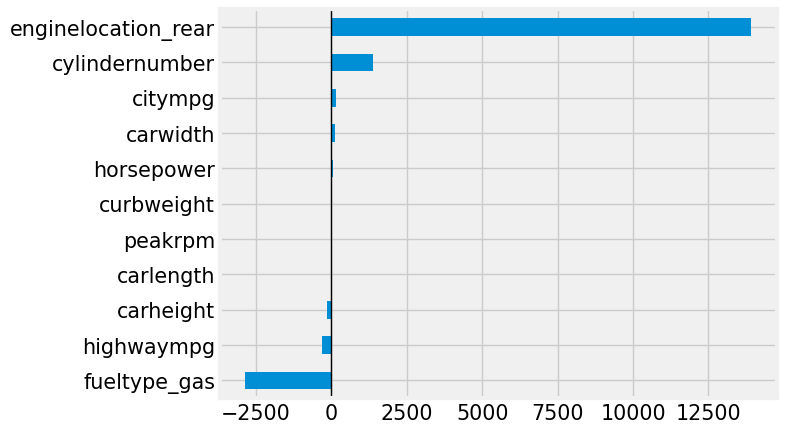

In [40]:
ax = coeffs.sort_values().plot(kind='barh')
ax.axvline(0, color='k', lw=1);

### Largest Coefficients 3 Positive and 3 Negative and Impact Explanation

Training Data:	R^2= 0.84	RMSE= 3224.59
Test Data:	R^2= 0.75	RMSE= 3656.03


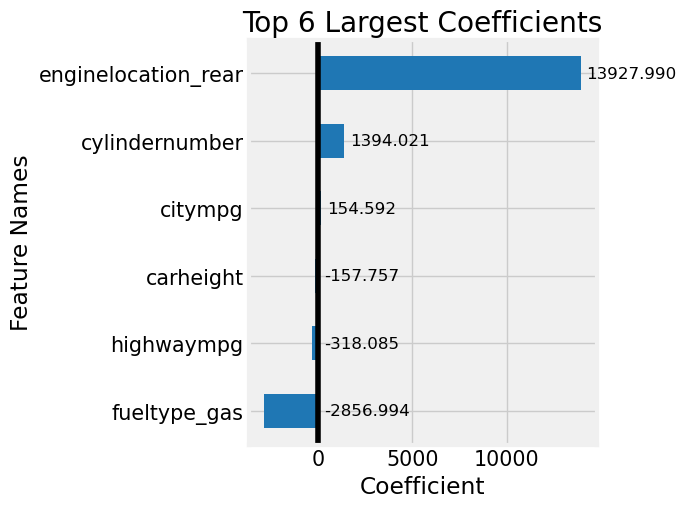

In [48]:
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)
plot_coeffs(coeffs,top_n=6,annotate=True, color='tab:blue');

**Top 3 Positive Coefficients**
- 'enginelocation_rear' (engine location is in the rear): 
    - If this is True, increases Price by \$13,927.99


- 'cylindernumber' (cylinder count): 
    - Each increase in the number of cylinders increases Price by \$1,394.02


- 'citympg' (miles per gallon in the city):
    - Each increase in mpg increases Price by \$154.59

**Top 3 Negative Coefficients**
- 'fueltype_gas' (if car fuel type is gas):
    - If True, decrease Price by \$2,856.99
    
    
- 'highwaympg' (miles per gallon on highway):
    - For each increase in highway mpg, decrease Price by \$318.09
    
    
- 'carheight':
    - For each single unit increase in the height of the car, decrease Price by \$157.76

## **Explain the Random Forest Model**



In [56]:
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.99	RMSE= 962.04
Test Data:	R^2= 0.83	RMSE= 3004.17


In [60]:
importances = get_importances(rf_reg)
importances

carlength             0.02
carwidth              0.11
carheight             0.01
curbweight            0.28
cylindernumber        0.08
horsepower            0.32
peakrpm               0.02
citympg               0.03
highwaympg            0.14
fueltype_gas          0.00
enginelocation_rear   0.00
Name: Feature Importance, dtype: float64

In [63]:
color_dict = get_color_dict(importances, top_n=6)

### Feature Importances Bar Graph

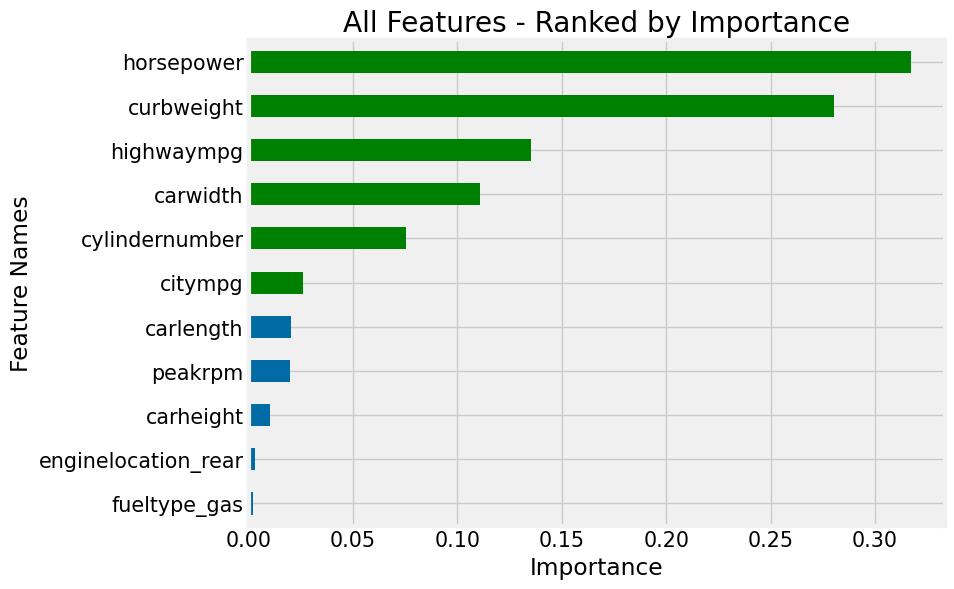

In [65]:
plot_importance_color(importances, figsize=(8,6), color_dict=color_dict);

**Top 6 Most Important Features**
- 'horsepower'
- 'curbweight'
- 'highwaympg'
- 'cardwidth'
- 'cylindernumber'
- 'citympg'

### Comparing with Top 6 Coefficients
- These features appear in the top 6 for both Coefficients and Feature Importance:
    - 'highwaympg'
    - 'cylindernumber'
    - 'citympg'

### Apply Shap to Explain the Random Forest Model

In [67]:
shap.initjs()

#### Sample SHAP
- Learning Platform instruction is for 500 samples but there are only 153 rows for X_train


- Will sample 100 with random_state=321

In [68]:
len(X_train_df)

153

In [74]:
X_shap = shap.sample(X_train_df,nsamples=100,random_state=321)
X_shap.head()

,carlength,carwidth,carheight,curbweight,cylindernumber,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,enginelocation_rear
99,173.40,65.20,54.70,"2,324.00",4.00,97.00,"5,200.00",27.00,34.00,1.00,0.00
138,156.90,63.40,53.70,"2,050.00",4.00,69.00,"4,900.00",31.00,36.00,1.00,0.00
82,173.20,66.30,50.20,"2,833.00",4.00,145.00,"5,000.00",19.00,24.00,1.00,0.00
86,172.40,65.40,51.60,"2,405.00",4.00,88.00,"5,000.00",25.00,32.00,1.00,0.00
79,157.30,63.80,50.80,"2,145.00",4.00,102.00,"5,500.00",24.00,30.00,1.00,0.00


In [75]:
len(X_shap)

100

In [76]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

99     8,949.00
138    5,118.00
82    12,629.00
86     8,189.00
79     7,689.00
         ...   
123    8,921.00
85     6,989.00
118    5,572.00
155    8,778.00
40    10,295.00
Name: price, Length: 100, dtype: float64

#### SHAP Model Explainer

In [77]:
explainer = shap.Explainer(rf_reg)
explainer

In [78]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [79]:
shap_values.shape

(100, 11)

#### SHAP Summary Plot Dot

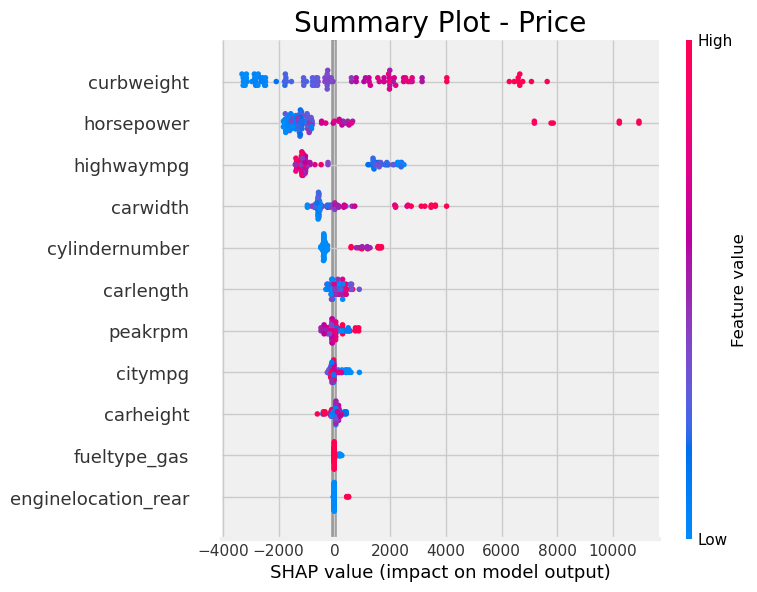

In [83]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, features= X_shap, show=False)
ax.set_title('Summary Plot - Price');

**Interpretation of Top 6 Features**


- 'curbweight':
    - Higher the weight (more red), more impact on increasing Price


- 'horsepower':
    - Seems to be that very high horsepower has a substantial impact on increasing Price
    
    
- 'highwaympg':
    - Lower mpg on highway, more impact on increasing Price
    
    
- 'carwidth':
    - Higher the width of the car, more impact on increasing Price
    
    
- 'cylindernumber':
    - More cylinders, more impact on increasing Price
    
    
- 'carlength':
    - Appears to be no significant impact on Price either way

# **Part 2**

## Load Libraries/Data

In [84]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

# list of named time zones
import pytz
#all_tzs = pytz.all_timezones
#len(all_tzs)

# import the statsmodels time series analysis api module
# seasonal decompose
import statsmodels.tsa.api as tsa

# get peaks (max point) of each season
from scipy.signal import find_peaks

import holidays
import datetime as dt
from holidays import country_holidays


import warnings
warnings.filterwarnings('ignore')

# Custom Functions

In [152]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [141]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

#ax1.yaxis.set_major_formatter(fmt_mill)
#ax2.yaxis.set_major_formatter(fmt_thous)

In [85]:
df = pd.read_csv('Data/us-covid-confirmed.csv')
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,22012020,23012020,24012020,25012020,26012020,27012020,28012020,29012020,30012020,31012020,01022020,02022020,03022020,04022020,...,09012023,10012023,11012023,12012023,13012023,14012023,15012023,16012023,17012023,18012023,19012023,20012023,21012023,22012023,23012023,24012023,25012023,26012023,27012023,28012023,29012023,30012023,31012023,01022023,02022023
0,84001001,US,USA,840,"1,001.00",Autauga,Alabama,US,32.54,-86.64,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19205,19205,19318,19318,19318,19318,19318,19318,19318,19389,19389,19389,19389,19389,19389,19389,19471,19471,19471,19471,19471,19471,19471,19530,19530
1,84001003,US,USA,840,"1,003.00",Baldwin,Alabama,US,30.73,-87.72,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,68182,68182,68518,68518,68518,68518,68518,68518,68518,68764,68764,68764,68764,68764,68764,68764,68983,68983,68983,68983,68983,68983,68983,69187,69187
2,84001005,US,USA,840,"1,005.00",Barbour,Alabama,US,31.87,-85.39,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7120,7120,7188,7188,7188,7188,7188,7188,7188,7258,7258,7258,7258,7258,7258,7258,7299,7299,7299,7299,7299,7299,7299,7339,7339
3,84001007,US,USA,840,"1,007.00",Bibb,Alabama,US,33.00,-87.13,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7808,7808,7855,7855,7855,7855,7855,7855,7855,7889,7889,7889,7889,7889,7889,7889,7919,7919,7919,7919,7919,7919,7919,7967,7967
4,84001009,US,USA,840,"1,009.00",Blount,Alabama,US,33.98,-86.57,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,17952,17952,18057,18057,18057,18057,18057,18057,18057,18130,18130,18130,18130,18130,18130,18130,18255,18255,18255,18255,18255,18255,18255,18349,18349


## **Melt DataFrame**

In [88]:
df.columns[0:11]

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
      dtype='object')

In [98]:
melted = pd.melt(df, id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 
                              'Admin2', 'Province_State', 'Country_Region', 
                              'Lat', 'Long_', 'Combined_Key'],
                 value_name='Confirmed', var_name='Date')
melted

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed
0,84001001,US,USA,840,"1,001.00",Autauga,Alabama,US,32.54,-86.64,"Autauga, Alabama, US",22012020,0
1,84001003,US,USA,840,"1,003.00",Baldwin,Alabama,US,30.73,-87.72,"Baldwin, Alabama, US",22012020,0
2,84001005,US,USA,840,"1,005.00",Barbour,Alabama,US,31.87,-85.39,"Barbour, Alabama, US",22012020,0
3,84001007,US,USA,840,"1,007.00",Bibb,Alabama,US,33.00,-87.13,"Bibb, Alabama, US",22012020,0
4,84001009,US,USA,840,"1,009.00",Blount,Alabama,US,33.98,-86.57,"Blount, Alabama, US",22012020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702931,84056039,US,USA,840,"56,039.00",Teton,Wyoming,US,43.94,-110.59,"Teton, Wyoming, US",02022023,12058
3702932,84056041,US,USA,840,"56,041.00",Uinta,Wyoming,US,41.29,-110.55,"Uinta, Wyoming, US",02022023,6317
3702933,84090056,US,USA,840,"90,056.00",Unassigned,Wyoming,US,0.00,0.00,"Unassigned, Wyoming, US",02022023,0
3702934,84056043,US,USA,840,"56,043.00",Washakie,Wyoming,US,43.90,-107.68,"Washakie, Wyoming, US",02022023,2729


### Format 'Date' to 'Datetime'
- Looks like 'Date' is set as Day, Month, Year

In [99]:
fmt = '%d%m%Y'

melted['Datetime'] = pd.to_datetime(melted['Date'], format=fmt)
melted

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Datetime
0,84001001,US,USA,840,"1,001.00",Autauga,Alabama,US,32.54,-86.64,"Autauga, Alabama, US",22012020,0,2020-01-22
1,84001003,US,USA,840,"1,003.00",Baldwin,Alabama,US,30.73,-87.72,"Baldwin, Alabama, US",22012020,0,2020-01-22
2,84001005,US,USA,840,"1,005.00",Barbour,Alabama,US,31.87,-85.39,"Barbour, Alabama, US",22012020,0,2020-01-22
3,84001007,US,USA,840,"1,007.00",Bibb,Alabama,US,33.00,-87.13,"Bibb, Alabama, US",22012020,0,2020-01-22
4,84001009,US,USA,840,"1,009.00",Blount,Alabama,US,33.98,-86.57,"Blount, Alabama, US",22012020,0,2020-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702931,84056039,US,USA,840,"56,039.00",Teton,Wyoming,US,43.94,-110.59,"Teton, Wyoming, US",02022023,12058,2023-02-02
3702932,84056041,US,USA,840,"56,041.00",Uinta,Wyoming,US,41.29,-110.55,"Uinta, Wyoming, US",02022023,6317,2023-02-02
3702933,84090056,US,USA,840,"90,056.00",Unassigned,Wyoming,US,0.00,0.00,"Unassigned, Wyoming, US",02022023,0,2023-02-02
3702934,84056043,US,USA,840,"56,043.00",Washakie,Wyoming,US,43.90,-107.68,"Washakie, Wyoming, US",02022023,2729,2023-02-02


### Set 'Datetime' as Index, Drop 'Date'

In [100]:
melted = melted.set_index('Datetime')
melted.drop(columns='Date', inplace=True)
melted

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Datetime,,,,,,,,,,,,
2020-01-22,84001001,US,USA,840,"1,001.00",Autauga,Alabama,US,32.54,-86.64,"Autauga, Alabama, US",0
2020-01-22,84001003,US,USA,840,"1,003.00",Baldwin,Alabama,US,30.73,-87.72,"Baldwin, Alabama, US",0
2020-01-22,84001005,US,USA,840,"1,005.00",Barbour,Alabama,US,31.87,-85.39,"Barbour, Alabama, US",0
2020-01-22,84001007,US,USA,840,"1,007.00",Bibb,Alabama,US,33.00,-87.13,"Bibb, Alabama, US",0
2020-01-22,84001009,US,USA,840,"1,009.00",Blount,Alabama,US,33.98,-86.57,"Blount, Alabama, US",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-02,84056039,US,USA,840,"56,039.00",Teton,Wyoming,US,43.94,-110.59,"Teton, Wyoming, US",12058
2023-02-02,84056041,US,USA,840,"56,041.00",Uinta,Wyoming,US,41.29,-110.55,"Uinta, Wyoming, US",6317
2023-02-02,84090056,US,USA,840,"90,056.00",Unassigned,Wyoming,US,0.00,0.00,"Unassigned, Wyoming, US",0


## **Filter Data**

### Filters
- Keep States:
    -  'New York', "New Jersey", "Pennsylvania", 'Delaware', 'Rhode Island', 'Maryland', "Virginia", "North Carolina"
    

- Keep Dates:
    - 05/2020 to Present

In [115]:
state_filter = melted['Province_State'].isin(['New York', "New Jersey", 
                                                   "Pennsylvania", 'Delaware', 
                                                   'Rhode Island', 'Maryland', 
                                                   "Virginia", "North Carolina"])
state_filter

Datetime
2020-01-22    False
2020-01-22    False
2020-01-22    False
2020-01-22    False
2020-01-22    False
              ...  
2023-02-02    False
2023-02-02    False
2023-02-02    False
2023-02-02    False
2023-02-02    False
Name: Province_State, Length: 3702936, dtype: bool

In [121]:
melted.loc['2020-05':]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Datetime,,,,,,,,,,,,
2020-05-01,84001001,US,USA,840,"1,001.00",Autauga,Alabama,US,32.54,-86.64,"Autauga, Alabama, US",43
2020-05-01,84001003,US,USA,840,"1,003.00",Baldwin,Alabama,US,30.73,-87.72,"Baldwin, Alabama, US",180
2020-05-01,84001005,US,USA,840,"1,005.00",Barbour,Alabama,US,31.87,-85.39,"Barbour, Alabama, US",42
2020-05-01,84001007,US,USA,840,"1,007.00",Bibb,Alabama,US,33.00,-87.13,"Bibb, Alabama, US",41
2020-05-01,84001009,US,USA,840,"1,009.00",Blount,Alabama,US,33.98,-86.57,"Blount, Alabama, US",41
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-02,84056039,US,USA,840,"56,039.00",Teton,Wyoming,US,43.94,-110.59,"Teton, Wyoming, US",12058
2023-02-02,84056041,US,USA,840,"56,041.00",Uinta,Wyoming,US,41.29,-110.55,"Uinta, Wyoming, US",6317
2023-02-02,84090056,US,USA,840,"90,056.00",Unassigned,Wyoming,US,0.00,0.00,"Unassigned, Wyoming, US",0


In [119]:
df_filtered = melted[state_filter]
df_filtered

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Datetime,,,,,,,,,,,,
2020-01-22,84010001,US,USA,840,"10,001.00",Kent,Delaware,US,39.09,-75.57,"Kent, Delaware, US",0
2020-01-22,84010003,US,USA,840,"10,003.00",New Castle,Delaware,US,39.58,-75.64,"New Castle, Delaware, US",0
2020-01-22,84080010,US,USA,840,"80,010.00",Out of DE,Delaware,US,0.00,0.00,"Out of DE, Delaware, US",0
2020-01-22,84010005,US,USA,840,"10,005.00",Sussex,Delaware,US,38.66,-75.39,"Sussex, Delaware, US",0
2020-01-22,84090010,US,USA,840,"90,010.00",Unassigned,Delaware,US,0.00,0.00,"Unassigned, Delaware, US",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-02,84051830,US,USA,840,"51,830.00",Williamsburg,Virginia,US,37.28,-76.71,"Williamsburg, Virginia, US",2280
2023-02-02,84051840,US,USA,840,"51,840.00",Winchester,Virginia,US,39.17,-78.17,"Winchester, Virginia, US",8107
2023-02-02,84051195,US,USA,840,"51,195.00",Wise,Virginia,US,36.97,-82.62,"Wise, Virginia, US",13721


In [120]:
df_filtered = df_filtered.loc['2020-05':]
df_filtered

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Datetime,,,,,,,,,,,,
2020-05-01,84010001,US,USA,840,"10,001.00",Kent,Delaware,US,39.09,-75.57,"Kent, Delaware, US",773
2020-05-01,84010003,US,USA,840,"10,003.00",New Castle,Delaware,US,39.58,-75.64,"New Castle, Delaware, US",1829
2020-05-01,84080010,US,USA,840,"80,010.00",Out of DE,Delaware,US,0.00,0.00,"Out of DE, Delaware, US",0
2020-05-01,84010005,US,USA,840,"10,005.00",Sussex,Delaware,US,38.66,-75.39,"Sussex, Delaware, US",2292
2020-05-01,84090010,US,USA,840,"90,010.00",Unassigned,Delaware,US,0.00,0.00,"Unassigned, Delaware, US",24
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-02,84051830,US,USA,840,"51,830.00",Williamsburg,Virginia,US,37.28,-76.71,"Williamsburg, Virginia, US",2280
2023-02-02,84051840,US,USA,840,"51,840.00",Winchester,Virginia,US,39.17,-78.17,"Winchester, Virginia, US",8107
2023-02-02,84051195,US,USA,840,"51,195.00",Wise,Virginia,US,36.97,-82.62,"Wise, Virginia, US",13721


## **Save as .csv**

In [122]:
df_filtered.to_csv('Data/data-for-tableau.csv')

## **Resample**

Resample the cases, grouped by states, to monthly frequency (based on the beginning of the calendar month) using sum as the aggregate function

In [123]:
df_ts = df_filtered.groupby('Province_State').resample('MS').sum()
df_ts

UID    code3           FIPS        Lat  \
Province_State Datetime                                                      
Delaware       2020-05-01   13026200899   130200   6,200,899.00   3,637.16   
               2020-06-01   12606000870   126000   6,000,870.00   3,519.83   
               2020-07-01   13026200899   130200   6,200,899.00   3,637.16   
               2020-08-01   13026200899   130200   6,200,899.00   3,637.16   
               2020-09-01   12606000870   126000   6,000,870.00   3,519.83   
...                                 ...      ...            ...        ...   
Virginia       2022-10-01  351756634603  3515400 216,634,603.00 154,885.24   
               2022-11-01  340409646390  3402000 209,646,390.00 149,888.94   
               2022-12-01  351756634603  3515400 216,634,603.00 154,885.24   
               2023-01-01  351756634603  3515400 216,634,603.00 154,885.24   
               2023-02-01   22693976426   226800  13,976,426.00   9,992.60   

                                Long_  Confirmed  
Province_State Datetime                           
Delaware       2020-05-01   -7,024.59     229083  
               2020-06-01   -6,797.99     312601  
               2020-07-01   -7,024.59     410198  
               2020-08-01   -7,024.59     503506  
               2020-09-01   -6,797.99     572135  
...                               ...        ...  
Virginia       2022-10-01 -323,712.03   65231936  
               2022-11-01 -313,269.71   64045669  
               2022-12-01 -323,712.03   67443271  
               2023-01-01 -323,712.03   69192486  
               2023-02-01  -20,884.65    4521592  

[272 rows x 6 columns]

### Unstack

In [126]:
unstacked = df_ts.unstack(level=0)
unstacked.head()

UID                                          \
Province_State     Delaware     Maryland   New Jersey      New York   
Datetime                                                              
2020-05-01      13026200899  67727160937  59919419779  166730583396   
2020-06-01      12606000870  65542413810  57986535270  161352177480   
2020-07-01      13026200899  67727160937  59919419779  166730583396   
2020-08-01      13026200899  67727160937  59919419779  166730583396   
2020-09-01      12606000870  65542413810  57986535270  161352177480   

                                                                        \
Province_State North Carolina  Pennsylvania Rhode Island      Virginia   
Datetime                                                                 
2020-05-01       265728282294  179768645763  18240093503  351756634603   
2020-06-01       257156402220  173969657190  17651703390  340409646390   
2020-07-01       265728282294  179768645763  18240093503  351756634603   
2020-08-01       265728282294  179768645763  18240093503  351756634603   
2020-09-01       257156402220  173969657190  17651703390  340409646390   

                  code3                                              \
Province_State Delaware Maryland New Jersey New York North Carolina   
Datetime                                                              
2020-05-01       130200   677040     598920  1666560        2656080   
2020-06-01       126000   655200     579600  1612800        2570400   
2020-07-01       130200   677040     598920  1666560        2656080   
2020-08-01       130200   677040     598920  1666560        2656080   
2020-09-01       126000   655200     579600  1612800        2570400   

                                                          FIPS                \
Province_State Pennsylvania Rhode Island Virginia     Delaware      Maryland   
Datetime                                                                       
2020-05-01          1796760       182280  3515400 6,200,899.00 23,160,937.00   
2020-06-01          1738800       176400  3402000 6,000,870.00 22,413,810.00   
2020-07-01          1796760       182280  3515400 6,200,899.00 23,160,937.00   
2020-08-01          1796760       182280  3515400 6,200,899.00 23,160,937.00   
2020-09-01          1738800       176400  3402000 6,000,870.00 22,413,810.00   

                                                                         \
Province_State    New Jersey      New York North Carolina  Pennsylvania   
Datetime                                                                  
2020-05-01     27,419,779.00 74,583,396.00 120,282,294.00 92,645,763.00   
2020-06-01     26,535,270.00 72,177,480.00 116,402,220.00 89,657,190.00   
2020-07-01     27,419,779.00 74,583,396.00 120,282,294.00 92,645,763.00   
2020-08-01     27,419,779.00 74,583,396.00 120,282,294.00 92,645,763.00   
2020-09-01     26,535,270.00 72,177,480.00 116,402,220.00 89,657,190.00   

                                                 Lat                       \
Province_State  Rhode Island       Virginia Delaware  Maryland New Jersey   
Datetime                                                                    
2020-05-01     12,093,503.00 216,634,603.00 3,637.16 29,027.10  26,226.47   
2020-06-01     11,703,390.00 209,646,390.00 3,519.83 28,090.74  25,380.46   
2020-07-01     12,093,503.00 216,634,603.00 3,637.16 29,027.10  26,226.47   
2020-08-01     12,093,503.00 216,634,603.00 3,637.16 29,027.10  26,226.47   
2020-09-01     11,703,390.00 209,646,390.00 3,519.83 28,090.74  25,380.46   

                                                                              \
Province_State  New York North Carolina Pennsylvania Rhode Island   Virginia   
Datetime                                                                       
2020-05-01     81,769.86     110,435.05    84,779.15     6,456.55 154,885.24   
2020-06-01     79,132.12     106,872.63    82,044.34     6,248.27 149,888.94   
2020-07-01     81,769.86     110,4

In [206]:
ts = unstacked['Confirmed']
ts.head(3)

Province_State,Delaware,Maryland,New Jersey,New York,North Carolina,Pennsylvania,Rhode Island,Virginia
Datetime,,,,,,,,
2020-05-01,229083,1183128,4477514,10799300,595911,1985343,381262,926151
2020-06-01,312601,1848484,5028481,11589235,1424785,2494459,481310,1644315
2020-07-01,410198,2374558,5518455,12634363,2990075,3190546,549884,2330822


### Line Graph per State

In [173]:
loc_3months = mdates.MonthLocator(interval=3)
# create the formatter to display 3-letter month names + 2-digit year
fmt_months = mdates.DateFormatter("%b")

## for major year ticks
loc_year = mdates.YearLocator()
fmt_year = mdates.DateFormatter("%Y")

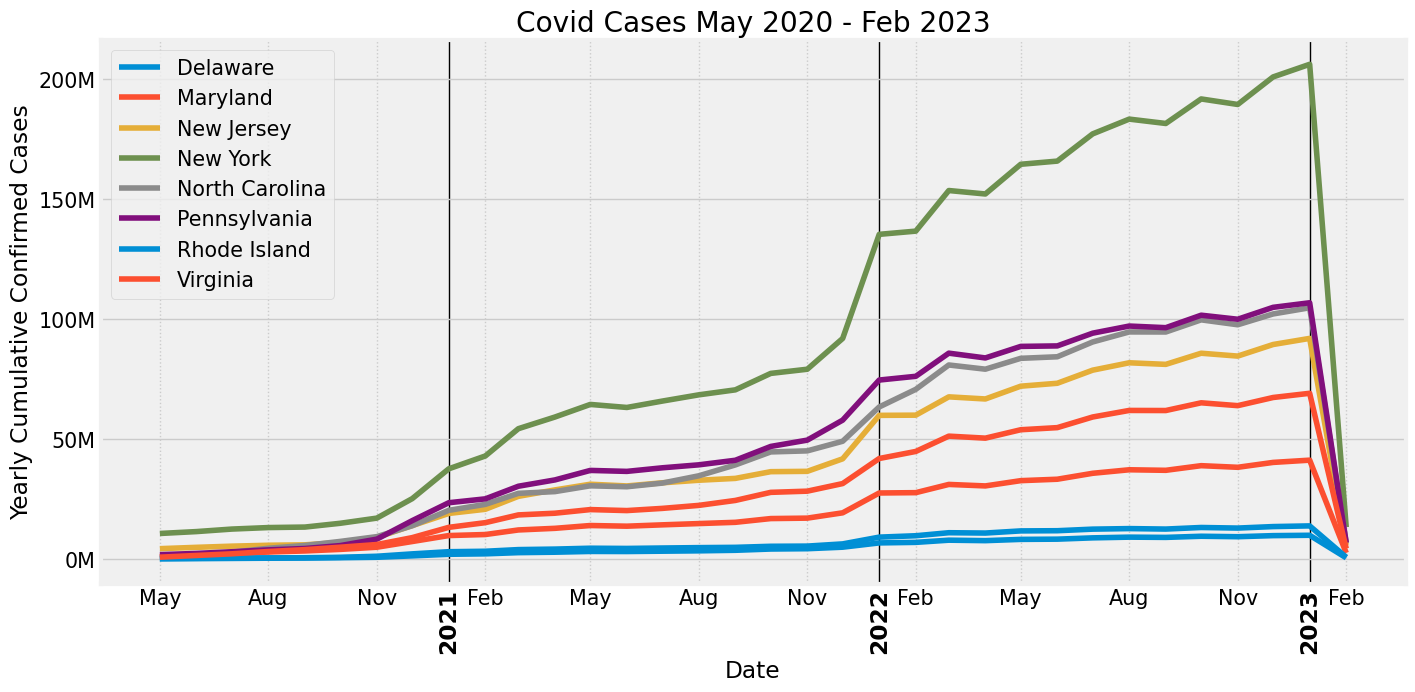

In [214]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(ts.index, ts.values)

ax.yaxis.set_major_formatter(fmt_mill)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize='large',fontweight='bold' ) 
##  customize minor ticks
ax.xaxis.set_minor_locator(loc_3months)
ax.xaxis.set_minor_formatter(fmt_months)
##  customize major ticks
ax.xaxis.set_major_locator(loc_year)
ax.xaxis.set_major_formatter(fmt_year)
##  Making major/minor gridlines visually distince
ax.grid(which='minor',axis='x',ls=":")
ax.grid(which='major',axis='x',color='k')
fig.autofmt_xdate(rotation=90,ha='center')

plt.title('Covid Cases May 2020 - Feb 2023')
plt.xlabel('Date')
plt.ylabel('Yearly Cumulative Confirmed Cases')
ax.legend(ts.columns);